In [ ]:
#!pip install albumentations==0.4.6

In [1]:
!pip install --quiet torch_lr_finder

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR, OneCycleLR
import albumentations as A
from albumentations.pytorch import ToTensorV2

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import cv2
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!git clone https://github.com/PRIYE/CNN_model_repo.git

Cloning into 'CNN_model_repo'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 16 (delta 5), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (16/16), 8.75 KiB | 8.75 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [7]:
from CNN_model_repo.custom_resnet import Custom_Res_Net

In [4]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda, 'Albumentations version', A.__version__)

CUDA Available? True Albumentations version 1.3.1


In [ ]:
from model import Dilated_Net
from utils import plot_performance

In [ ]:
# Train Phase transformations
train_transforms = A.Compose([
                      A.PadIfNeeded(min_height=40, min_width=40, always_apply=True),
                      A.RandomCrop(height=32, width=32, always_apply=True),
                      A.HorizontalFlip(p=0.5),
                      #A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
                      A.CoarseDropout(max_holes = 1, max_height=8, max_width=8, min_holes = 1, min_height=8, min_width=8
                                      , fill_value=(0.49139968, 0.48215841, 0.44653091),mask_fill_value = None),
                      #A.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1, p=0.2),
                      A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)),
                      ToTensorV2()
                              ])

# Test Phase transformations
test_transforms = A.Compose([
                    A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)),
                    ToTensorV2()
                          ])

In [ ]:
class Albumentations_CIFAR10(datasets.CIFAR10):
  def __init__(self, root="../data", train=True, download=True, transform=None):
    super().__init__( root=root, train=train, download=download, transform=transform)

  def __getitem__(self, index):
    image, label = self.data[index], self.targets[index]

    if self.transform is not None:
      transformed = self.transform(image=image)
      image = transformed["image"]
    return image, label

In [ ]:
train = Albumentations_CIFAR10('../data', train=True, download=True, transform=train_transforms)
test = Albumentations_CIFAR10('../data', train=False, download=True, transform=test_transforms)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
#train_data = train.train_data
train_data = train.data/255

print('[Train]')
print(' - Numpy Shape:', train.data.shape)
print(' - Tensor Shape:', torch.tensor(train.data).size())
print(' - min:', torch.min(torch.tensor(train_data)))
print(' - max:', torch.max(torch.tensor(train_data)))
print(' - mean:', train_data.mean(axis = (0,1,2)))
print(' - std:', train_data.std(axis = (0,1,2)))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)


[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - Tensor Shape: torch.Size([50000, 32, 32, 3])
 - min: tensor(0., dtype=torch.float64)
 - max: tensor(1., dtype=torch.float64)
 - mean: [0.49139968 0.48215841 0.44653091]
 - std: [0.24703223 0.24348513 0.26158784]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([512, 3, 32, 32])
torch.Size([512])


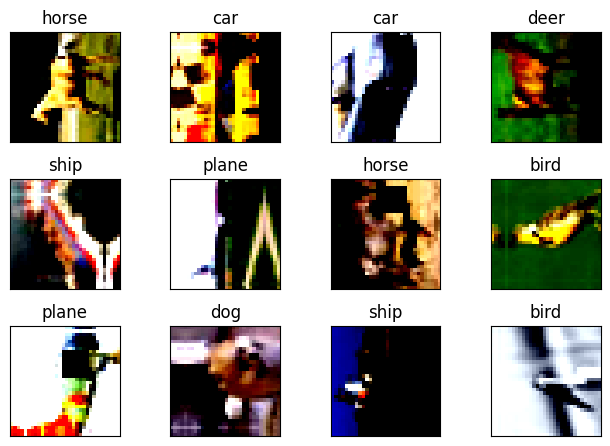

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
batch_data, batch_label = next(iter(train_loader))
fig = plt.figure()
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.tight_layout()
    plt.imshow(np.transpose(batch_data[i].numpy(), (2, 1, 0)), cmap='gray')
    plt.title(f'{classes[batch_label[i].item()]}')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [ ]:
def calc_activation_shape(dim, ksize, dilation=(1, 1), stride=(1, 1), padding=(0, 0)):
  def shape_each_dim(i):
    odim_i = dim[i] + 2 * padding[i] - dilation[i] * (ksize[i] - 1) - 1
    return (odim_i / stride[i]) + 1
  return shape_each_dim(0), shape_each_dim(1)

def calc_receptive_field(Rin,ksize, stride, Jin, dilation=1):
    new_k = dilation*(ksize - 1) + 1
    #if dilation>1:
    Jnew = Jin*stride
    #else:
    #Jnew = stride*Jin
    return Rin + (new_k-1)*Jin, Jnew

In [ ]:
print('******** prep 1 **********')
output_channel_size = calc_activation_shape(dim=(32,32), ksize=(3,3), dilation=(1, 1), stride=(1, 1), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=1 ,ksize=3, stride=1, Jin=1, dilation=1)
print('Receptive Field', output_receptive_field)

print('******** Layer 1 **********', f'Jin {Jnew}')

output_channel_size = calc_activation_shape(dim=output_channel_size, ksize=(3,3), dilation=(1, 1), stride=(1, 1), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=output_receptive_field ,ksize=3, stride=1,Jin=Jnew, dilation=1)
print('Receptive Field', output_receptive_field)

output_channel_size = calc_activation_shape(dim=output_channel_size, ksize=(2,2), dilation=(1, 1), stride=(2, 2), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=output_receptive_field ,ksize=2, stride=2, Jin=Jnew, dilation=1)
print('Receptive Field', output_receptive_field)

print('******** Res 1 **********', f'Jin {Jnew}')
output_channel_size = calc_activation_shape(dim=output_channel_size, ksize=(3,3), dilation=(1, 1), stride=(1, 1), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=output_receptive_field ,ksize=3, stride=1,Jin=Jnew, dilation=1)
print('Receptive Field', output_receptive_field)

output_channel_size = calc_activation_shape(dim=output_channel_size, ksize=(3,3), dilation=(1, 1), stride=(1, 1), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=output_receptive_field ,ksize=3, stride=1,Jin=Jnew, dilation=1)
print('Receptive Field', output_receptive_field)

print('******** Layer 2 **********', f'Jin {Jnew}')
output_channel_size = calc_activation_shape(dim=output_channel_size, ksize=(3,3), dilation=(1, 1), stride=(1, 1), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=output_receptive_field ,ksize=3, stride=1, Jin=Jnew, dilation=1)
print('Receptive Field', output_receptive_field)

output_channel_size = calc_activation_shape(dim=output_channel_size, ksize=(2,2), dilation=(1, 1), stride=(2, 2), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=output_receptive_field ,ksize=2, stride=2, Jin=Jnew, dilation=1)
print('Receptive Field', output_receptive_field)

print('******** Layer 3 **********', f'Jin {Jnew}')
output_channel_size = calc_activation_shape(dim=output_channel_size, ksize=(3,3), dilation=(1, 1), stride=(1, 1), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=output_receptive_field ,ksize=3, stride=1, Jin=Jnew, dilation=1)
print('Receptive Field', output_receptive_field)

output_channel_size = calc_activation_shape(dim=output_channel_size, ksize=(2,2), dilation=(1, 1), stride=(2, 2), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=output_receptive_field ,ksize=2, stride=2, Jin=Jnew, dilation=1)
print('Receptive Field', output_receptive_field)

print('******** Res 2 **********', f'Jin {Jnew}')
output_channel_size = calc_activation_shape(dim=output_channel_size, ksize=(3,3), dilation=(1, 1), stride=(1, 1), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=output_receptive_field ,ksize=3, stride=1,Jin=Jnew, dilation=1)
print('Receptive Field', output_receptive_field)

output_channel_size = calc_activation_shape(dim=output_channel_size, ksize=(3,3), dilation=(1, 1), stride=(1, 1), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=output_receptive_field ,ksize=3, stride=1,Jin=Jnew, dilation=1)
print('Receptive Field', output_receptive_field)

print('******** Layer 4 **********', f'Jin {Jnew}')
output_channel_size = calc_activation_shape(dim=output_channel_size, ksize=(4,4), dilation=(1, 1), stride=(4, 4), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=output_receptive_field ,ksize=4, stride=4,Jin=Jnew, dilation=1)
print('Receptive Field', output_receptive_field)



******** prep 1 **********
Output Channel size (32.0, 32.0)
Receptive Field 3
******** Layer 1 ********** Jin 1
Output Channel size (32.0, 32.0)
Receptive Field 5
Output Channel size (17.0, 17.0)
Receptive Field 6
******** Res 1 ********** Jin 2
Output Channel size (17.0, 17.0)
Receptive Field 10
Output Channel size (17.0, 17.0)
Receptive Field 14
******** Layer 2 ********** Jin 2
Output Channel size (17.0, 17.0)
Receptive Field 18
Output Channel size (9.5, 9.5)
Receptive Field 20
******** Layer 3 ********** Jin 4
Output Channel size (9.5, 9.5)
Receptive Field 28
Output Channel size (5.75, 5.75)
Receptive Field 32
******** Res 2 ********** Jin 8
Output Channel size (5.75, 5.75)
Receptive Field 48
Output Channel size (5.75, 5.75)
Receptive Field 64
******** Layer 4 ********** Jin 8
Output Channel size (1.9375, 1.9375)
Receptive Field 88


In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Custom_Res_Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
           Dropout-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
          Dropout-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.64E-05


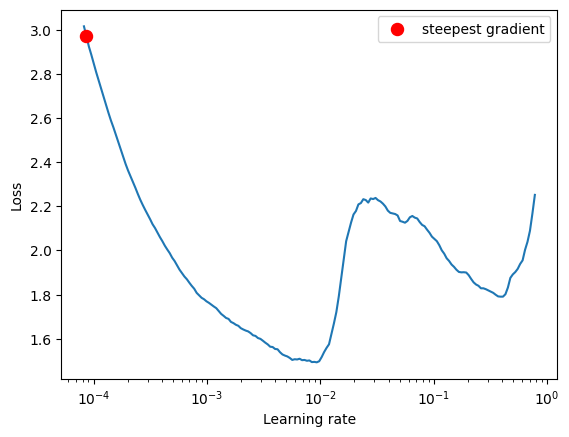

In [ ]:
from torch_lr_finder import LRFinder
model = Custom_Res_Net().to(device)
optimizer_lr = optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer_lr, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=1, num_iter=200, step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [ ]:
print(f"Lowest loss is at LR : {lr_finder.history['lr'][np.argmin(lr_finder.history['loss'])]}")
print(f"The LR which has sharpest downward slope is : {float(8.22E-05):.15f}")

Lowest loss is at LR : 0.009297318105416816
The LR which has sharpest downward slope is : 0.000082200000000


In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, criterion, epoch):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader,  criterion ):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [ ]:
model = Custom_Res_Net().to(device)
criterion = nn.CrossEntropyLoss()
num_epochs = 24
ler_rate = 0.009297318105416816
optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)
scheduler = OneCycleLR(
        optimizer,
        max_lr= ler_rate,
        steps_per_epoch=len(train_loader),
        epochs=num_epochs,
        pct_start=5/num_epochs,
        div_factor=10,
        three_phase=False,
        final_div_factor=10,
        anneal_strategy='linear'
    )
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}')
    train(model, device, train_loader, optimizer, criterion, epoch)
    scheduler.step()
    test(model, device, test_loader, criterion)

Epoch 1


Train: Loss=1.3444 Batch_id=97 Accuracy=40.71: 100%|██████████| 98/98 [00:19<00:00,  4.97it/s]


Test set: Average loss: 0.0030, Accuracy: 4655/10000 (46.55%)

Epoch 2


Train: Loss=0.9432 Batch_id=97 Accuracy=58.80: 100%|██████████| 98/98 [00:19<00:00,  4.98it/s]


Test set: Average loss: 0.0019, Accuracy: 6580/10000 (65.80%)

Epoch 3


Train: Loss=0.7571 Batch_id=97 Accuracy=69.24: 100%|██████████| 98/98 [00:19<00:00,  4.91it/s]


Test set: Average loss: 0.0016, Accuracy: 7326/10000 (73.26%)

Epoch 4


Train: Loss=0.7004 Batch_id=97 Accuracy=75.24: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s]


Test set: Average loss: 0.0013, Accuracy: 7679/10000 (76.79%)

Epoch 5


Train: Loss=0.6147 Batch_id=97 Accuracy=78.94: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s]


Test set: Average loss: 0.0012, Accuracy: 8011/10000 (80.11%)

Epoch 6


Train: Loss=0.4411 Batch_id=97 Accuracy=81.15: 100%|██████████| 98/98 [00:20<00:00,  4.85it/s]


Test set: Average loss: 0.0010, Accuracy: 8306/10000 (83.06%)

Epoch 7


Train: Loss=0.5113 Batch_id=97 Accuracy=82.75: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s]


Test set: Average loss: 0.0009, Accuracy: 8419/10000 (84.19%)

Epoch 8


Train: Loss=0.4529 Batch_id=97 Accuracy=84.57: 100%|██████████| 98/98 [00:20<00:00,  4.85it/s]


Test set: Average loss: 0.0009, Accuracy: 8387/10000 (83.87%)

Epoch 9


Train: Loss=0.4761 Batch_id=97 Accuracy=85.50: 100%|██████████| 98/98 [00:20<00:00,  4.84it/s]


Test set: Average loss: 0.0008, Accuracy: 8551/10000 (85.51%)

Epoch 10


Train: Loss=0.4251 Batch_id=97 Accuracy=86.73: 100%|██████████| 98/98 [00:20<00:00,  4.86it/s]


Test set: Average loss: 0.0009, Accuracy: 8479/10000 (84.79%)

Epoch 11


Train: Loss=0.3880 Batch_id=97 Accuracy=87.45: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s]


Test set: Average loss: 0.0008, Accuracy: 8698/10000 (86.98%)

Epoch 12


Train: Loss=0.3785 Batch_id=97 Accuracy=88.17: 100%|██████████| 98/98 [00:20<00:00,  4.85it/s]


Test set: Average loss: 0.0007, Accuracy: 8788/10000 (87.88%)

Epoch 13


Train: Loss=0.3085 Batch_id=97 Accuracy=88.51: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s]


Test set: Average loss: 0.0007, Accuracy: 8809/10000 (88.09%)

Epoch 14


Train: Loss=0.2990 Batch_id=97 Accuracy=89.21: 100%|██████████| 98/98 [00:20<00:00,  4.84it/s]


Test set: Average loss: 0.0007, Accuracy: 8853/10000 (88.53%)

Epoch 15


Train: Loss=0.2941 Batch_id=97 Accuracy=89.56: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s]


Test set: Average loss: 0.0007, Accuracy: 8760/10000 (87.60%)

Epoch 16


Train: Loss=0.3459 Batch_id=97 Accuracy=89.87: 100%|██████████| 98/98 [00:20<00:00,  4.83it/s]


Test set: Average loss: 0.0007, Accuracy: 8797/10000 (87.97%)

Epoch 17


Train: Loss=0.3095 Batch_id=97 Accuracy=90.31: 100%|██████████| 98/98 [00:20<00:00,  4.78it/s]


Test set: Average loss: 0.0006, Accuracy: 8911/10000 (89.11%)

Epoch 18


Train: Loss=0.3221 Batch_id=97 Accuracy=90.41: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s]


Test set: Average loss: 0.0006, Accuracy: 8980/10000 (89.80%)

Epoch 19


Train: Loss=0.2742 Batch_id=97 Accuracy=91.00: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s]


Test set: Average loss: 0.0006, Accuracy: 8923/10000 (89.23%)

Epoch 20


Train: Loss=0.2571 Batch_id=97 Accuracy=91.15: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s]


Test set: Average loss: 0.0006, Accuracy: 8927/10000 (89.27%)

Epoch 21


Train: Loss=0.3378 Batch_id=97 Accuracy=90.97: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s]


Test set: Average loss: 0.0006, Accuracy: 8943/10000 (89.43%)

Epoch 22


Train: Loss=0.2773 Batch_id=97 Accuracy=91.54: 100%|██████████| 98/98 [00:20<00:00,  4.86it/s]


Test set: Average loss: 0.0006, Accuracy: 8981/10000 (89.81%)

Epoch 23


Train: Loss=0.2921 Batch_id=97 Accuracy=91.99: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]


Test set: Average loss: 0.0006, Accuracy: 9002/10000 (90.02%)

Epoch 24


Train: Loss=0.3295 Batch_id=97 Accuracy=91.86: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]


Test set: Average loss: 0.0006, Accuracy: 8970/10000 (89.70%)



In [ ]:
#epoch 5  Accuracy=54.67 , 60.59%

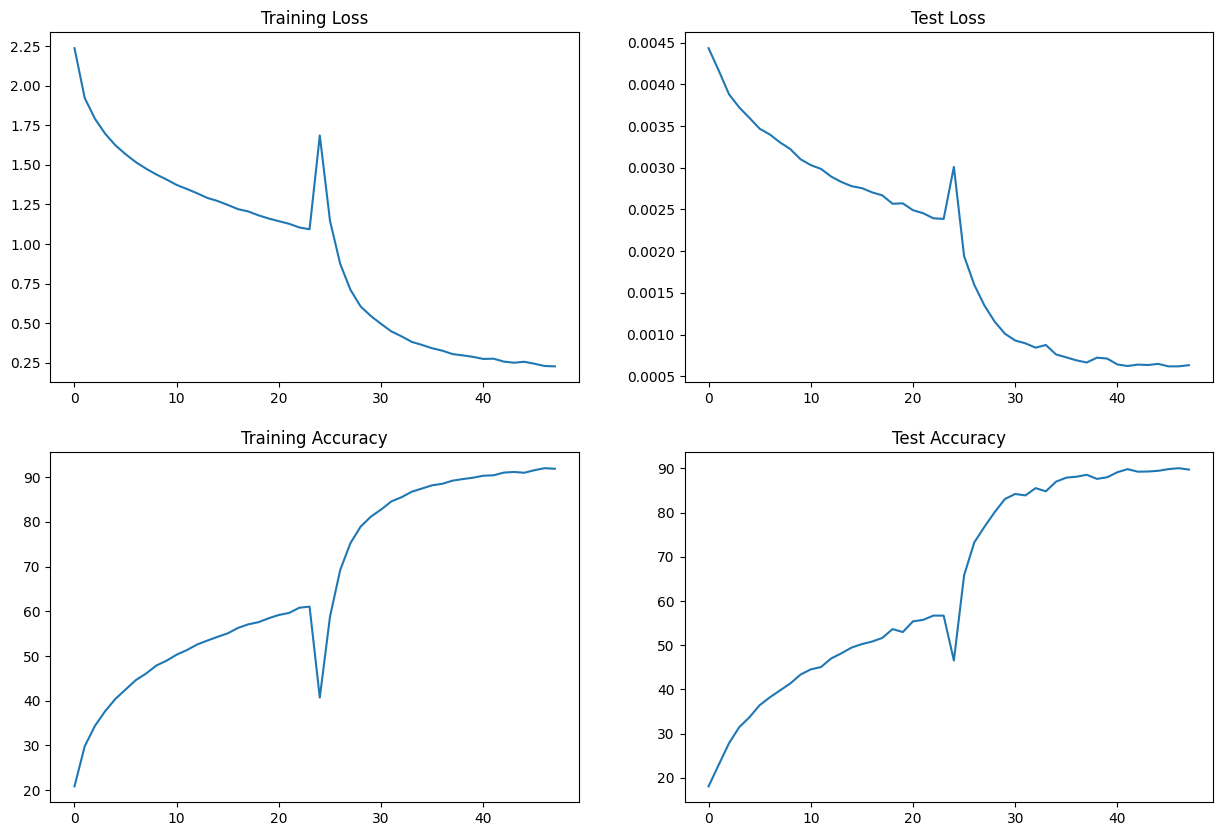

In [ ]:
#train_losses_lst = [t_items.item() for t_items in train_losses]
plot_performance(train_losses, train_acc, test_losses, test_acc)

In [ ]:
model.eval()
test_loss = 0
correct = 0
i =0
misclassified_dict = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        #test_loss += nn.CrossEntropyLoss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        t = pred.eq(target.view_as(pred)).view(-1, target.size(0))
        t = t.cpu().numpy().reshape(-1)
        for ind,val in enumerate(t):
          if not val :
            temp_dict = {}
            temp_dict['data'] = data[ind].cpu().numpy()
            temp_dict['target'] = target[ind]
            temp_dict['pred'] = pred[ind]
            misclassified_dict.append(temp_dict)

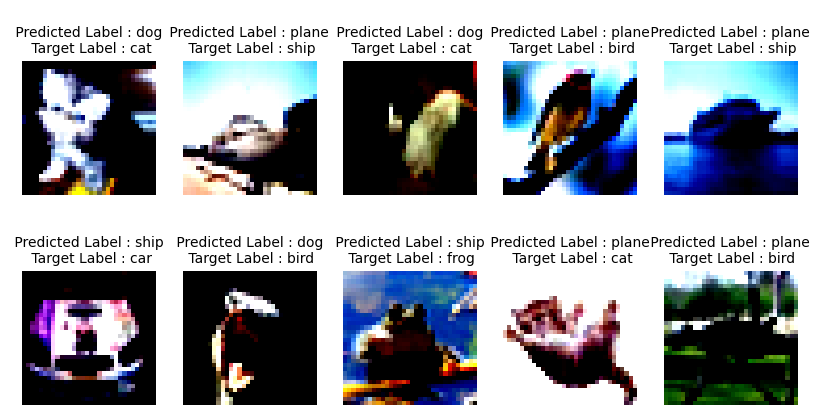

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
display_images = misclassified_dict[:10]
index = 0
fig = plt.figure(figsize=(10,5))
for img in display_images:
    image = img['data']
    pred = classes[img['pred']]
    actual = classes[img['target']]
    ax = fig.add_subplot(2, 5, index+1)
    ax.axis('off')
    ax.set_title(f'\n Predicted Label : {pred} \n Target Label : {actual}',fontsize=10)
    ax.imshow(np.transpose(image, (1, 2, 0)))
    index = index + 1
plt.show()